# 1. Term Structure, Interest Rate Swap

금융공학을 공부하다 보면 $r$, 즉 이자율이라는 변수를 자주 볼 수 있습니다. <br>
프로젝트를 현실에 적용하기 위해서는 이 이자율이라는 변수도 현실에서 적절하게 선택해야 합니다.<br>
하지만, 현실에는 이자율이라 불리는 지표가 너무 많기에 어떤 변수를 선택해야 하는지 알기 어렵습니다.<br>
첫 세션에서는 금융공학에 쓰이는 이자율을 구하는 방법과 제일 간단한 이자율 파생상품에 대해 공부합니다. 

In [1]:
import pandas as pd
import numpy as np
from scipy import optimize

## 1-1. Interest Rate

금융공학에서 이자율은 보통 미래 시점에서의 현금 흐름을 현재가치화하는데 사용됩니다.<br>
여러 방법이 있지만 보통 $e^{rt}$를 곱해서 사용합니다.<br>
이때 유의해야 할 점은, 할인이나 할증 과정에서 이자가 발생하지 않는다는 것입니다.<br>
즉, 적절한 할인이나 할증을 위해서는 이자가 발생하지 않을 경우의 이자율이 필요하다는 것입니다.<br>
이 때, 이자가 발생하지 않는 채권의 이자율을 현물이자율(Spot Rate)라고 부르며, 이는 앞으로 설명할 모든 이자율과 금융공학의 기본이 됩니다.<br>
이제 이 현물이자율은 어떻게 도출하며, 금융공학에 사용되는 다른 금리는 어떤 것이 있는지 공부하겠습니다.

## 1-2 이자율의 종류

우선 금융공학에서 사용되는 여러 가지 이자율의 종류와 정의를 알아보겠습니다. <br>

현물 이자율 $r(t,T)$ : 무이표 채권의 이자율을 말하며, $(t,T)$의 기간 동안 적용되는 연속복리 만기수익률을 의미합니다

선도이자율 $F(t,T,S)$ : $t$ 시점에서 예측하는 $(T,S)$의 기간 동안 적용되는 수익률을 의미합니다.

단기 이자율 $r(t)$ : $(t,t+dt)$의 아주 짧은 기간 동안 적용되는 수익률을 의미합니다.

이 중 할인에 사용되는 금리는 현물 이자율이므로, 현재 채권 데이터로 현물 이자율 곡선을 그리는 방법을 소개하겠습니다.

## 1-3 Bootstrapping

단기 채권은 보통 쿠폰이 없는 할인채로 발행되기에, 그대로 혹은 약간의 연산만 거치면 바로 현물 이자율을 구할 수 있습니다.<br>
하지만 장기 채권은 쿠폰이 있는 이표채로 발행되기에 해당 채권의 수익률은 할인에 적합하지 않습니다. <br>
채권 데이터에 이러한 이표채가 포함되어 있는 경우 부트스트래핑이라는 기법을 사용합니다.<br>
부트스트래핑의 과정은 다음과 같습니다. <br>

1. 할인채나 복리채는 그대로 현물 이자율로 사용한다.

2. 이표채의 경우 쿠폰 각각을 하나의 복리채로 설정하고, 복리채 전체의 합이 채권의 가격이 되는 만기별 현물 이자율을 계산한다.

### Example

한 경제주체가 발행한 채권이 다음과 같다고 가정합니다.

만기 6개월, 금리 2%의 복리채 <br>
만기 1년, 금리 2.5%의 복리채 <br>
만기 2년, 이표 주기 1년, 표면금리 3%의 이표채 <br>
만기 3년, 이표 주기 1년, 표면금리 3.5%의 이표채 <br>
이표채의 가격은 모두 액면가와 같음

우선 처음 2개의 복리채의 수익률을 적용합니다.

In [2]:
ZR = pd.DataFrame(index = [0,0.5,1,2,3], columns = ["R"])
ZR.loc[0,'R'] = 0
ZR.loc[0.5,'R'] = 0.02
ZR.loc[1,'R'] = 0.025

만기 2년짜리 이표채는 발행 1년 뒤 원금의 3%, 2년 뒤 원금과 원금의 3% 총 원금의 103%의 현금흐름이 발생합니다.<br>
이 이표채의 가격이 액면가와 같으므로, 액면가를 10000원으로 설정하고 각 현금흐름을 하나의 복리채로 설정하면 다음 방정식이 나옵니다. <br>
$$10000 = {300\over{1+R(1)}} + {10300 \over{(1+R(2))}^2}$$
$R(1) = 0.02$를 대입하면 다음과 같은 식이 나옵니다.
$$10000 = {300 \over 1.02} + {10300 \over {(1+R(2))}^2} = 294.12 + {10300 \over {(1+R(2))}^2}$$
이 방정식을 풀면 2년 만기 현물 이자율을 구할 수 있습니다.
$$R(2) = 0.0302$$
만기 3년짜리 이표채에도 같은 과정을 반복하면 됩니다.
$$10000 = {350\over{1+R(1)}} + {350 \over{(1+R(2))}^2} + {10350 \over{(1+R(3))}^3}$$
정리하면
$$10000 = 343.14 + 329.78 + {10350 \over{(1+R(3))}^3}$$
$$R(3) = 0.0353$$
를 얻을 수 있습니다.

<Axes: >

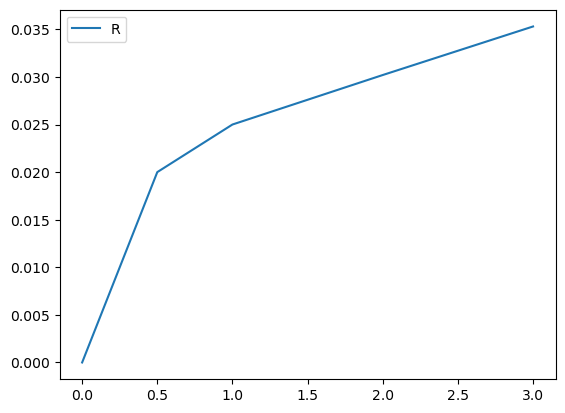

In [3]:
ZR.loc[2,'R'] = 0.0302
ZR.loc[3,'R'] = 0.0353
ZR.plot()

## 1-4 채권 가격 데이터로부터 현물 이자율 도출

이처럼 부트스트래핑을 이용하면 만기별 현물 이자율을 도출할 수 있습니다. 하지만 현실의 채권은 이렇게 현금흐름의 시기별로 만기가 알맞게 존재하지 않기 때문에 선형보간이나, 스플라인 등을 적절히 이용해야 합니다. 국고채 데이터와 보간을 이용해서 실제 현물 이자율을 도출해 보겠습니다. 지금부터 할인시에는 연속 이자율을 사용합니다.

In [4]:
Bond = pd.read_excel("국채가격.xlsx")

In [5]:
Bond

,발행일,만기일,잔여만기,표면이율,주기,가격
0,2024-09-10,2024-12-10,0.25,0.00000,0.0,9913
1,2020-09-10,2025-09-10,1.00,0.01125,0.5,9873
2,2021-03-10,2026-03-10,1.50,0.01250,0.5,9744
3,2019-12-10,2029-12-10,5.25,0.01375,0.5,9254
4,2020-09-10,2040-09-10,16.00,0.01500,0.5,8085
5,2016-03-10,2046-03-10,21.50,0.02000,0.5,8252
6,2022-03-10,2027-03-10,2.50,0.02375,0.5,9863
7,2022-03-10,2052-03-10,27.50,0.02500,0.5,9398
8,2022-09-10,2052-09-10,28.00,0.03125,0.5,10379
9,2023-06-10,2033-06-10,8.75,0.03250,0.5,10220


이표는 모두 3,6,9,12월에 있으므로 현물이자율을 0.25년 단위로 계산합니다.
우선 기준금리라고 불리는 91일 할인채 금리가 3.5%니 0.25년 현물이자율은 0.035입니다.
그리고 채권들을 만기가 짧은 순서대로 나열합니다.

In [6]:
ZRB = pd.DataFrame(columns = ['R(t)'], index = range(1,113))
ZRB.index/=4
ZRB.iloc[0,0] = 0.035

In [7]:
Bond = Bond.sort_values(by = ["잔여만기"])

In [8]:
Bond

,발행일,만기일,잔여만기,표면이율,주기,가격
0,2024-09-10,2024-12-10,0.25,0.00000,0.0,9913
1,2020-09-10,2025-09-10,1.00,0.01125,0.5,9873
2,2021-03-10,2026-03-10,1.50,0.01250,0.5,9744
6,2022-03-10,2027-03-10,2.50,0.02375,0.5,9863
3,2019-12-10,2029-12-10,5.25,0.01375,0.5,9254
11,2010-12-10,2030-12-10,6.25,0.04750,0.5,11357
9,2023-06-10,2033-06-10,8.75,0.03250,0.5,10220
10,2013-12-10,2033-12-10,9.25,0.03750,0.5,10659
4,2020-09-10,2040-09-10,16.00,0.01500,0.5,8085
5,2016-03-10,2046-03-10,21.50,0.02000,0.5,8252


이제 현물 이자율을 구하기 위해, 주어진 현물이자율과 만기, 표면이율, 채권의 만기의 현물이자율이 주어지면 중간에 해당하는 만기의 현물이자율은 선형 보간으로 처리해 그 조건 하의 채권가격을 구하는 함수를 만듭니다.

In [9]:
def Maturityzerotoprice(maturityspot,NA,ZR,known,maturity,coupon,firstcoupon,market):
    Zero = ZRB.loc[0.25:maturity,:].copy()
    Zero.loc[maturity,'R(t)'] = maturityspot
    price = 0
    for i in range(1,int((maturity-known)*4)+1):
        Zero.loc[known+0.25*i,'R(t)'] = ((0.25*i)*maturityspot+(maturity-known-0.25*i)*Zero.loc[known,'R(t)'])/(maturity-known)
    for j in range(1,int(maturity*2)):
        price += NA*coupon*0.5*np.exp(-(firstcoupon+0.5*j)*Zero.loc[firstcoupon+0.5*j,'R(t)'])
    price += NA*np.exp(-maturityspot*maturity)
    return price-market

이제 이 함수의 함숫값과 채권의 가격을 같게 만드는 현물이자율이 해당 채권의 만기에서의 현물이자율입니다,

In [10]:
known = 0.25
for i in range(1,Bond.shape[0]):
    NA = 10000
    maturity = Bond.iloc[i,2]
    coupon = Bond.iloc[i,3]
    firstcoupon = Bond.iloc[i,2]%0.5
    market = Bond.iloc[i,5]
    r = optimize.fsolve(Maturityzerotoprice,0.03,args = (10000,ZRB,known,maturity,coupon,firstcoupon,market))[0]
    ZRB.loc[maturity,'R(t)'] = r
    ZRB["R(t)"][known:maturity]=  pd.to_numeric(ZRB["R(t)"][known:maturity]).interpolate(method='linear')
    known = maturity


이렇게 현재 시점에서 현물이자율을 계산했습니다.

<Axes: >

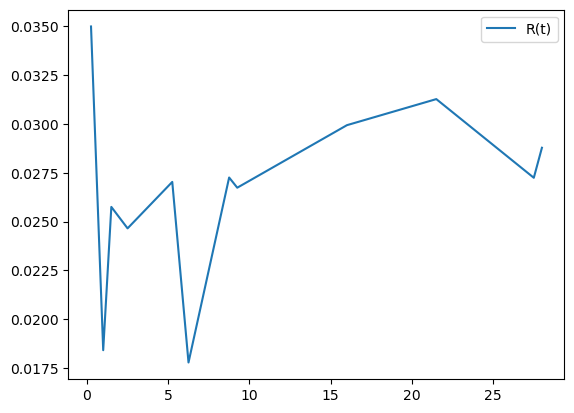

In [11]:
ZRB.plot()

## 1-5 이자율 스왑

이제 이런 현물 이자율을 이용한 가장 간단한 파생상품인 이자율 스왑에 대해 알아보겠습니다. <br>
이자율 스왑은 변동금리와 고정금리를 교환하는 계약을 말합니다. <br>
이자율 스왑의 가격결정은 고정금리를 결정하는 것인데, 변동금리 측면의 현금흐름의 현재가치의 총합과 고정금리 측면에서의 현금흐름의 현재가치의 총합이 같게 되는 고정금리를 정하면 됩니다. <br>
변동금리 측면의 현금흐름(Float Leg)를 구하는 것은 미래의 특정 기간 동안 적용되는 금리를 현재 시점에서 계산하는 것으로, 이를 달리 말하면 특정 기간 동안의 선도금리를 구하는 것입니다. 이자율 스왑은 사전에 결정된 주기마다 한 번 씩의 이자를 교환하는 계약이므로, 연속복리가 아닌 단리 선도금리를 구하면 됩니다.<br>
선도금리를 구하는 법은 무차익 거래 라는 원칙을 이용하는 것입니다. 두 투자자가 10000원을 서로 다른 방법으로 투자하려 합니다. A라는 투자자는 만기 2년의 복리채를 구입하고, B라는 투자자는 만기 1년의 복리채를 구입하고 해당 채권의 만기 지급액 전체에 대해 지금으로부터 1년 후 시점부터 1년동안 적용되는 단리 선도금리 계약을 체결했다고 가정합니다. 이 두 거래를 같은 상대방과 체결했다면, 무차익 거래의 원칙에 따라 두 거래의 수익률은 같아야 합니다. A가 구입한 채권의 수익률은 연 4%이고 B가 구입한 채권의 수익률이 연 3%라고 설정합니다, 그러면 2년 후 A가 받을 금액은 다음과 같습니다.<br>
$${CF}_A = 10000 \times (1.04)^{2} = 10816$$
B가 체결한 선도금리 계약의 금리는 $f(0,1,2)$이므로, 2년 후 B가 받을 금액은 다음과 같습니다.<br>
$${CF}_B = 10000 \times (1.03) \times (1+f(0,1,2))$$
이 금액이 A가 받을 금액인 10816원과 같아야 하므로 $f(0,1,2)$는 다음과 같습니다.<br>
$$(1+f(0,1,2)) = {{10816}\over{10000\times(1.03)}} \rightarrow f(0,1,2) = 0.05009...$$
이러한 논리를 이용해서 현물 이자율 곡선이 주어졌을 때, 각 기간별 선도금리를 구할 수 있습니다. 현물 이자율 곡선으로부터 기간별 할인계수를 구하고, 다음 식에 대입하여 단리 선도금리를 구할 수 있습니다.
$$f(0,T,S) = {{{{e^{-R(T)T}}\over{e^{-R(S)S}}}-1}\over{S-T}}$$
이제 이를 활용하여 Float Leg의 현재가치를 구하면 다음과 같습니다.
$$Float Leg = \sum {e^{-R(t_{n})t_{n}}}\times f(0,t_{n-1},t_{n})$$
이때, $t_n , t_{n+1}$은 각각 n번째, n+1번째 이자지급일을 의미하며 단위는 년입니다. 그리고 $t_0 = 0$입니다.<br>
이자 지급 주기를 3개월로 설정하고, 10년 만기 이자율 스왑의 가격결정을 실행해 보겠습니다. 우선 현물 이자율 곡선과 두 시점이 주어지면 시점 사이 기간 동안 적용되는 단리 선도금리를 구하는 함수를 만듭니다. 이때, 곡선에서 주어지지 않은 만기의 이자율은 선형보간을 이용하여 계산합니다. 그를 위해 선형보간을 실행하는 함수도 제작합니다.

In [12]:
'''x가 xa와 xb 사이에 있고, f(xa) = ya, f(xb)=yb를 알 경우 f(x)를 구하는 함수'''
def linear(xa,xb,ya,yb,x): 
    if xa==x:
        return ya
    elif xb==x:
        return yb
    else:
        if xa>xb:
            return ((xa-x)*yb+(x-xb)*ya)/(xa-xb)
        else:
            return ((xb-x)*ya+(x-xa)*yb)/(xb-xa)
    
'''선도 단기금리를 구하는 함수'''
def forward(curveT,curve,T,S):
    if (S<T):
        return -999
    elif (S==T):
        return 0
    '''선형보간을 이용하여 S와 T 시점에서의 현물이자율과 할인계수를 계산'''
    supT = curveT[-1]
    infT = curveT[0]
    supS = curveT[-1]
    infS = curveT[0]
    NT = curveT.shape[0]
    for i in range(1,NT):
        if curveT[i]<=T:
            infT = curveT[i]
        if curveT[NT-i]>=T:
            supT = curveT[NT-i]
        if curveT[i]<=S:
            infS = curveT[i]
        if curveT[NT-i]>=S:
            supS = curveT[NT-i]
    '''할인계수를 이용해 선도금리를 계산'''
    RT = linear(infT,supT,curve.loc[infT][0],curve.loc[supT][0],T)
    RS = linear(infS,supS,curve.loc[infS][0],curve.loc[supS][0],S)
    f = ((np.exp(-RT*T)/np.exp(-RS*S))-1)/(S-T)
    return f

시험삼아 11.5년부터 11.8년까지의 선도 단기금리를 계산해 보겠습니다.

In [13]:
forward(ZRB.index,ZRB,11.5,11.8)

0.033576066135230155

이제 이자율스왑의 가격결정을 진행하겠습니다. 현물 이자율은 위에서 구한 것을 사용하고, 만기는 10년, 이자 지급주기는 3개월, 원금은 10000원으로 설정합니다. 우선 이자 지급주기별로 선도금리를 구합니다. 이 때, 제일 처음의 선도금리는 $f(0,0,0.25)$이므로 현물이자율을 그대로 사용하면 됩니다.

In [14]:
NA = 10000
IRS = pd.DataFrame(index = range(1,41), columns = ["forward","float","Discount Factor"])
IRS.index /=4

In [15]:
IRS.iloc[0,0] = ZRB.loc[0.25][0]
IRS.iloc[0,1] = ZRB.loc[0.25][0]*NA
IRS.iloc[0,2] = np.exp(-ZRB.loc[0.25][0]*0.25)
for i in range(1,40):
    IRS.iloc[i,0] = forward(ZRB.index,ZRB,i*0.25,(i+1)*0.25)
    IRS.iloc[i,2] = np.exp(-ZRB.loc[(i+1)*0.25][0]*0.25*(i+1))
    IRS.iloc[i,1] = IRS.iloc[i,0]*NA

In [16]:
IRS

,forward,float,Discount Factor
0.25,0.035,350.0,0.991288
0.50,0.024013,240.125699,0.985373
0.75,0.012902,129.023274,0.982205
1.00,0.001823,18.227601,0.981757
1.25,0.036938,369.381396,0.972774
1.50,0.044356,443.557376,0.962105
1.75,0.023901,239.014319,0.956391
2.00,0.023349,233.485141,0.95084
2.25,0.022796,227.956722,0.945452
2.50,0.022243,222.429063,0.940224


이자율 곡선에서 음수의 기울기를 가지는 부분이 존재해 선도금리도 음수가 나왔습니다. 음수의 현금흐름을 가정하고 진행합니다.<br>
이제 각 시점에서의 현금흐름의 할인가를 모두 더한 Float Leg의 가치를 구합니다.

In [17]:
np.sum(IRS['float']*IRS["Discount Factor"])

9492.104522285385

이제 고정금리 수취자의 각 시점에서의 현금흐름이 1이라고 가정하고 Fixed Leg의 가치를 구합니다.

In [18]:
np.sum(1*IRS["Discount Factor"])

35.36678546165185

이제 Float Leg의 가치를 이 값으로 나눈 수가 고정금리 수취자의 각 시점에서의 현금흐름이 되게 하는 금리를 구하면 됩니다.

In [19]:
FixedCF = np.sum(IRS['float']*IRS["Discount Factor"])/np.sum(1*IRS["Discount Factor"])

이제 이 값을 현금흐름으로 가지기 위한 금리를 구하면 이자율스왑의 가격결정이 끝납니다.

In [20]:
rate = FixedCF/NA
rate

0.02683903667913969

즉 변동 금리로 국채 금리를 사용할 경우, 10년 만기 이자율스왑 금리는 2.684%입니다.